### Implementation
* Move to Python3
* Git hub update
* Load Pierre protein list
* Check for exisiting path between any node and a seed node after edge trimming
* Remove network not connected with seed node 

### Study
$\Delta$ SimPct treshold

 * How many networks
 * Tabulate individual protein degree across the generated networks

| Protein| 80% | 60% | ... | 10% |
| ------ | --- | --- | --- | --- |
| XXX    | 22  | 10  | ... | NA  |



GO analysis:
* Global tablechart of GO terms occurences across the network
* For given Protein and its 1st neighbors, display the GO annotations distribution of the proteins and their templates

Note montage necessaire

    sshfs glaunay@arwen://mobi/group/divisome /Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/arwen  -o umask=0002,allow_other,defer_permissions,IdentityFile=~/.ssh/id_rsa
    
Example BLAST utilisé
```shell
gunzip -c ~/work/projects/pneumocoque/JM_Rebuild/arwen/2017_10_04_DUPLICATE_RESULTS/INTACT_VERSUS_R6R/BLAST_OUTPUT/P0/P0CI74/blast.out.gz | less
```

Gestion des IDs de Intact
Travail sur un subset (head 200)
> /home/lbarlet/WorkOnIntact/subset_intact.txt

split pour récup deux première colonnes 
ensuite trie pour savoir quelle ID est la plus présentes,
la seconde, ...

/!\ la deuxième ne doit pas présenter la première, etc /!\


TODO 

  1. Récuperer interaction experiemntals suplémentaires
  2. Alignement de séquences sur protéines du divisome
  3. Définition de blocs
  4. Métrique homologie basée sur la similarité dans ces blocs.



In [1]:
import sys
import os
import subprocess
sys.path.append('/Users/guillaumelaunay/work/projects/pneumocoque/omegaLoMo/lib')
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteinsExt/src")
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteins/src")

%load_ext autoreload

In [2]:
import pandas
import json

def loadSeedList(lType='all'):
    rootDir='/Users/guillaumelaunay/work/projects/pneumocoque/lists'
    fileMap = {
        'phino' : 'DivAlreadyKnow_litt_phino.txt',
        'massida' : 'DivAlreadyKnow_litt_massida.txt',
        'barletMerge': 'divKnownR6.txt',
        'garcia' : 'pierre_uniprot_DL.tsv',
        'all' : 'current_merge.txt'
    }
    if lType not in fileMap:
        raise IndexError("no set named " + lType)
        
    pFrame = pandas.read_csv( rootDir + '/' + fileMap[lType], sep='\t', lineterminator='\n')
    return [ uniprotID for uniprotID in pFrame.loc[:]["Entry"] ]



* MITAB_file and filterIds can be filled when reading serialized data, or read from scratch, using input files.
* MITAB_file contains IntAct informations, restricted to physical interactions. 
It is a subset of the informations
from /mobi/group/divisome/physical_intact.mitab.txt, after serialization by an external python script.
* filterIds contains information about S pneumoniae
* intactR6filtered_topology is a dictionary, with pairs of UniProt Ids of proteins from IntAct interactions, that match with R6 sequences,
non redundant.

## Combining experimental evidences and homology relationship

### $I^{st}$ input *psicquic.MitabTopology* object

##### Previously pickled psicquic.MitabTopology object (see R6 topology notebook)

It can be viewed as a tree representation of an adjacency matrix
with non-zero cell elements storing list of mitab experimental evidences.

The actual data structure is a 2 level dictionnary of uniprotID keys referencing list of mitab informations


```json
{
    psicquicInteractorID : {
        psicquicInteractorID : [ psqDataObject , ...]
    }
    
}

```

API description

In [3]:
import pickle
#mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.H50.mitabToplogy.pickle"
mitabTopologyPickle="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_safe.mitabToplogy.pickle"
mitabTopologyObject = None
with open(mitabTopologyPickle, 'rb') as fP:
    mitabTopologyObject = pickle.load(fP)
print("Number of interaction unpickled", len(mitabTopologyObject) )

Number of interaction unpickled 54993


In [4]:
mitabTopologyObject["P38801"]["P24783"]

[uniprotkb:P24783	uniprotkb:P38801	intact:EBI-5602|uniprotkb:Q05456|uniprotkb:D6W169	intact:EBI-1909|uniprotkb:D3DL32	psi-mi:dbp2_yeast(display_long)|uniprotkb:DBP2(gene name)|psi-mi:DBP2(display_short)|uniprotkb:YNL112W(locus name)|uniprotkb:N1945(orf name)|uniprotkb:DEAD box protein 2(gene name synonym)|uniprotkb:p68-like protein(gene name synonym)	psi-mi:lrp1_yeast(display_long)|uniprotkb:LRP1(gene name)|psi-mi:LRP1(display_short)|uniprotkb:Like an rRNA processing protein 1(gene name synonym)|uniprotkb:rRNA processing protein 47(gene name synonym)|uniprotkb:RRP47(gene name synonym)|uniprotkb:YC1D(gene name synonym)|uniprotkb:Yeast C1D domain-containing protein(gene name synonym)|uniprotkb:YHR081W(locus name)	psi-mi:"MI:0111"(dihydrofolate reductase reconstruction)	Tarassov et al. (2008)	pubmed:18467557|mint:MINT-6673767|imex:IM-14275	taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)	taxid:559292(yeast)|taxid:559292(Saccharomyces cerevisiae)	psi-mi:"MI:0915"(physical associa

### $II^{nd}$ input *homology tree-like* document

Two level tree storing homology relationship between psicquic entries (**PSQ**) (primary keys) and
target proteome (**TP**) entries (secondary keys)
Leaves are array which contains one tuple per HSP (currently only one HSP)
HSP informations are

 **TP** sequence Length**,** **TP**_hsp start position**,** **TP**_hsp stop position**,** **PSQ**_sequence Length**,** **PSQ**_hsp start position**,** **PSQ**_hsp stop position**,** HSP positive match number**,** HSP identical match number**,** HSP eValue

```json
{
"P97760": {"P66709": [["311", "5", "235", "275", "5", "272", "95", "45", "4.79675e-27"]]},
"P98084": {"Q59947": [["1963", "262", "811", "750", "24", "572", "176", "95", "2.1715e-07"]], "Q8DQN5": [["1876", "191", "395", "750", "52", "281", "75", "47", "1.90067e-06"]]},
}
```


In [4]:
homologyFile="/Users/guillaumelaunay/tmp/buildNetwork2/uniprot_R6_homology.json"

## Building network Topology


##### **buildEdges ** 
Performs the homolog expansion

**args**:None

##### **resetEdges** 
Any network can be reverted to the state obtained at **buildEdge** completion

**args**:None
##### **trimEdges**
Discard homology relationship violating treshold-based constraints.
An edge without remaining homology relationship is removed

**args**: optional,named
 * idPct
 * simPct
 * cvPct
 
##### **nodes**
A dictionary attribute with network node and their supporting PSQ protein. 
```
{
    node_UniprotID : { PSQ_uniprotID, ... }
}
```



In [44]:
%autoreload 2


import omega

In [65]:
om = omega.omegaTopology(mitabTopologyObject, homologyFile)
om.buildEdges()

seedList=loadSeedList()


def trimPruneTest(omegaObj, idPct, _seedList):
    print("Current number of edges " + str(om.edgeNumber) )
    om.trimEdges(idPct=idPct)
    print(str(om.edgeNumber) + ' edges after triming' )
    G=om.prune(*_seedList)
    print(str(om.edgeNumber) + ' edges after pruning' )
    return G


84127  interactions unpacked from  54993


In [66]:
trimPruneTest(om, 10.00, seedList)

Current number of edges 84127
1100  interactions trimmed from total  84127
83027 edges after triming
83011 edges after pruning


In [69]:
G=trimPruneTest(om, 40.00, seedList)

Current number of edges 26611
83075  interactions trimmed from total  84127
1052 edges after triming
1004 edges after pruning


In [71]:
om.jupyterNodeView()

Q8DNC3,142
P0A336,43
Q8CWT3,39
Q8CWN9,36
Q8DPS0,34
Q8DRQ3,33
P59661,30
Q8DQN2,26
Q8DQD4,25
P63788,22
Q8DQL1,22


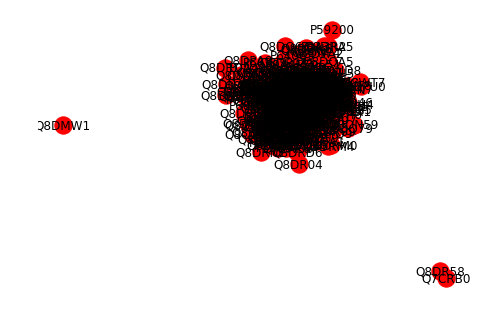

In [72]:
nx.draw(G, with_labels=True)

In [68]:
trimPruneTest(om, 20.00, seedList)

Current number of edges 1004
57493  interactions trimmed from total  84127
26634 edges after triming
26611 edges after pruning


## Node template assignment robustness to similarity treshold

In [149]:
import matplotlib.pyplot as plt

In [ ]:
def singleLineChart(nodeID, topologyObject, _seedList, idPctMin=10.0, step=5.0):
    for idPct in range(idPctMin, 100.0 + step, step):
        G = trimPruneTest(topologyObject, idPct, _seedList):
        

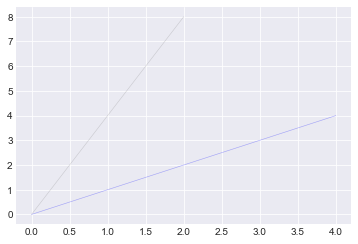

In [159]:
plt.style.use('seaborn-darkgrid')
plt.plot([0,1,2],[0,4,8], marker='', color='grey', linewidth=0.6, alpha=0.3)
plt.plot([0,2,4],[0,2,4], marker='', color='blue', linewidth=0.6, alpha=0.3)


## Enriching network

### Building supporting uniprot collection

In [84]:
import pyproteinsExt.uniprot as uniprot
from pyproteinsExt.uniprot import EntryEncoder


uColl = uniprot.getUniprotCollection()
uColl.setCache(location='/Users/guillaumelaunay/work/data/uniprot')
uniprot.proxySetting(https="http://ftprox.ibcp.fr:3128", http="http://ftprox.ibcp.fr:3128")

Acknowledged 0 entries (/Users/guillaumelaunay)
Changing cache location to /Users/guillaumelaunay/work/data/uniprot
Reindexing /Users/guillaumelaunay/work/data/uniprot
Acknowledged 11306 entries (/Users/guillaumelaunay/work/data/uniprot)
!!Proxy set to {'https': 'http://ftprox.ibcp.fr:3128', 'http': 'http://ftprox.ibcp.fr:3128'}


In [73]:
om.nodes

{'P0A2W7': {'P0A2W6', 'P96618'},
 'P0A2Y7': {'P31104'},
 'P0A336': {'O69289',
  'P0A335',
  'P0A6F5',
  'P10809',
  'P19882',
  'P42383',
  'P78012',
  'Q05972',
  'Q9VPS5',
  'Q9ZN50'},
 'P0A3B8': {'P80700'},
 'P0A3R0': {'O25011', 'P0A746'},
 'P0A3R2': {'P49850'},
 'P0A3Y4': {'P00950', 'P07738', 'P15259', 'P16290', 'P18669'},
 'P0A452': {'P16971', 'Q0P7V6'},
 'P0A472': {'O83268', 'P02394', 'P0A7K2', 'P36210', 'Q9PI32'},
 'P0A476': {'P41204', 'P56041', 'Q9PLX8'},
 'P0A484': {'Q50310'},
 'P0A496': {'O83239', 'P0A7Q6', 'P52864'},
 'P0A4A8': {'P17293', 'P53732', 'P75546'},
 'P0A4B4': {'Q03246', 'Q50309', 'Q9PLY0'},
 'P0A4B6': {'P0A7U3', 'P21476', 'P75576'},
 'P0A4C4': {'P21465', 'P41205', 'P73314'},
 'P0A4D8': {'O25029', 'P0A8J8', 'P96614'},
 'P0A4J0': {'P00579', 'P06224', 'P55993', 'P74565', 'Q59996'},
 'P0A4J7': {'P04179', 'P0A4J6', 'P0AGD3', 'P54375', 'Q0PBW9'},
 'P0A4M0': {'P0AES6', 'P22447', 'P55992', 'P77966', 'P78016'},
 'P0A4M6': {'O25151', 'P0A862', 'P80864', 'Q9PPE0', 'Q9ZKE7'},

In [143]:
# Create a collection of all uniprot entities in a network
class NetworkUniprotCollection:
    def __init__(self, omegaTopologyObject, uniprotMainCollection):
        self.networkUP = {}
        self.upDic = omegaTopologyObject.nodes
        for n in self.upDic:
            l = [n] + list(self.upDic[n])
            for x in l:
                if x not in self.networkUP:
                    self.networkUP[x] = uniprotMainCollection.get(x)
        # write to FS if fetched were performed
        uniprotMainCollection.serialize()
        print("loaded" + str(len(self)) + ' uniprot entries')
    
    def __len__(self):
        return len(self.networkUP)
    
    def GOview(self):
        goChart = uniprot.keyWordChart([ self.networkUP[x] for x in self.networkUP ])

        return htmlTable([ ( x[0], len(x[1]) ) for x in goChart ], ['GO term', 'Occurence'])

class htmlTable:
    def __init__(self, data, headers):
        self.data = data
        self.headers = headers
    def _repr_html_(self):
        htmlString = '<table><thead><th>' + '</th><th>'.join(self.headers) + '</th></thead><tbody>'
        for datum in self.data:
            htmlString += '<tr><td>' + '</td><td>'.join([ str(d) for d in datum ]) + '</td></tr>'

        htmlString += '</tbody></table>'

        return htmlString



In [144]:
netUniColl = NetworkUniprotCollection(om, uColl)
uniprotJsonString = json.dumps({"registry" : netUniColl.networkUP },  cls=EntryEncoder)
#uniprotJsonString

serializing uniprot collection
0 entries updated, total pool is 11306
serializing pfam collection
0 entries updated, total pool is 11221
loaded1192 uniprot entries


In [10]:
tag="uniprot_id40NTW"

jsonBean = om.dump()

with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".json", "w") as fp:
    fp.write(str(jsonBean).replace("\'", "\"")[:-1] + ", " + uniprotJsonString[1:] )

### Building supporting mitab collection

* Filtering _mitabObject_ for pair of template founds in the network
* write a mitab formated file of the filtered interactions

In [19]:
tColl = om.templateZipPair()
mitabTopologyObject.autoAppendable=True
mitabAsStr = ''
for t1, t2, d in tColl:
     mitabAsStr +=  '\n'.join( [ str(psq) for psq in mitabTopologyObject[t1][t2] ] )

with open("/Users/guillaumelaunay/tmp/buildNetwork2/" + tag + ".mitab", "w") as fp:
    fp.write(mitabAsStr)

## Graphs Functions

Utility functions to 
  + Load specific seed datasets
    ```python
    seedList = loadSeedList('all' OR 'phino' OR 'massida')
    ```
  + dump network topology under json format compliant with [Dforce,D3--style](https://bl.ocks.org/vasturiano/02affe306ce445e423f992faeea13521)
   ```python
    networkAsD3_dict = nEncode(G)
    with open('interactome.json', 'w') as outfile:
        json.dump(networkAsD3_dict, outfile)
    ```

## Miscellanous network properties


#### Go term distribution

In [146]:
netUniColl.GOview()

GO:0005737:C:cytoplasm{ECO:0000501},414
GO:0005524:F:ATP binding{ECO:0000501},404
GO:0005829:C:cytosol{ECO:0000318},316
GO:0006412:P:translation{ECO:0000501},138
GO:0003735:F:structural constituent of ribosome{ECO:0000318},133
GO:0046872:F:metal ion binding{ECO:0000501},122
GO:0000287:F:magnesium ion binding{ECO:0000501},106
GO:0003677:F:DNA binding{ECO:0000501},98
GO:0005886:C:plasma membrane{ECO:0000314},89
GO:0019843:F:rRNA binding{ECO:0000501},86
GO:0042802:F:identical protein binding{ECO:0000353},85


## Node template assignment robustness to similarity treshold

* Defines a range of Pct Similiarity treshold values to prune network
* Foreach treshold store Node degrees `[{'nodeRef': Q8DQD4, 'degree': 96}, ...]`

#### Utility functions
* doSnaphots
* writeSnapshots

In [9]:
def doSnapshots(G, _min=30, _max=100, step=20):
    gallery = {}
    for t in range(_min, _max, step):
        print("Minimal pct similarity", t)
        G = iObj2.graph( seedNodes=seedList[:], simPct=float(t) )
        gallery[t] = snapShotDegree(G)
    
    return gallery

def writeSnapshots(gallery, fileOut="/Users/guillaumelaunay/work/projects/pneumocoque/JM_Rebuild/omegaLoMo/gallery.json"):
    asStr = {}
    for t in gallery:
        asStr[t] = []
        for e in gallery[t]:
            asStr[t].append( { str(k) : str(e[k]) for k in e } )

    with open(fileOut, "w") as f:
        json.dump(asStr, f)
    print ("All snapshots written at", fileOut)

def snapShotDegree(G):
    d = nx.degree(G)
    return sorted( [ { 'nodeRef' : k[0], 'degree' : k[1] } for k in d ], key=lambda x: x['degree'], reverse=True)



Minimal pct similarity 30
Total number of pruned edges is 18252 / 90266
Deleting 1 nodes unconnected to seed
Minimal pct similarity 50
Total number of pruned edges is 86328 / 90266
Deleting 31 nodes unconnected to seed
Minimal pct similarity 70
Total number of pruned edges is 90065 / 90266
Deleting 101 nodes unconnected to seed
Minimal pct similarity 90
Total number of pruned edges is 90141 / 90266
Deleting 42 nodes unconnected to seed


In [43]:
print(gallery[30][:1],gallery[50][:1])

[{'nodeRef': Q8DPJ9, 'degree': 820}] [{'nodeRef': Q8DQD4, 'degree': 96}]


### Horizontal bar chart representation of the degrees of the most connected node at each treshold stage
 * Sort Node per decreasing connectivity
   - Take the 20 first id's at SimPct 50
   
 * Make a BarChart

[Text(0,0,'Q8DPJ9'),
 Text(0,0,'Q8DNS0'),
 Text(0,0,'Q8DRI0'),
 Text(0,0,'P67283'),
 Text(0,0,'Q8DQV2'),
 Text(0,0,'Q8DN05'),
 Text(0,0,'Q8DQN5'),
 Text(0,0,'Q8DNP9'),
 Text(0,0,'Q8DRL6'),
 Text(0,0,'Q8CYG6'),
 Text(0,0,'Q8DQD4'),
 Text(0,0,'Q8DPC2'),
 Text(0,0,'Q8DPK4'),
 Text(0,0,'P0A336'),
 Text(0,0,'Q8DMX2'),
 Text(0,0,'Q8DQ84'),
 Text(0,0,'Q8DR73'),
 Text(0,0,'Q8DNA3'),
 Text(0,0,'P63788'),
 Text(0,0,'P64063'),
 Text(0,0,'P59661'),
 Text(0,0,'Q8CWN9'),
 Text(0,0,'Q8DRB3'),
 Text(0,0,'Q8DPS0'),
 Text(0,0,'Q8CWT2'),
 Text(0,0,'Q8DQL6'),
 Text(0,0,'Q8CWT4'),
 Text(0,0,'P63589'),
 Text(0,0,'P65947'),
 Text(0,0,'Q8DNI9'),
 Text(0,0,'P59661'),
 Text(0,0,'Q8CWN9'),
 Text(0,0,'Q8DRB3'),
 Text(0,0,'Q8DPS0'),
 Text(0,0,'Q8CWT2'),
 Text(0,0,'Q8DQL6'),
 Text(0,0,'Q8CWT4'),
 Text(0,0,'P63589'),
 Text(0,0,'P65947'),
 Text(0,0,'Q8DNI9')]

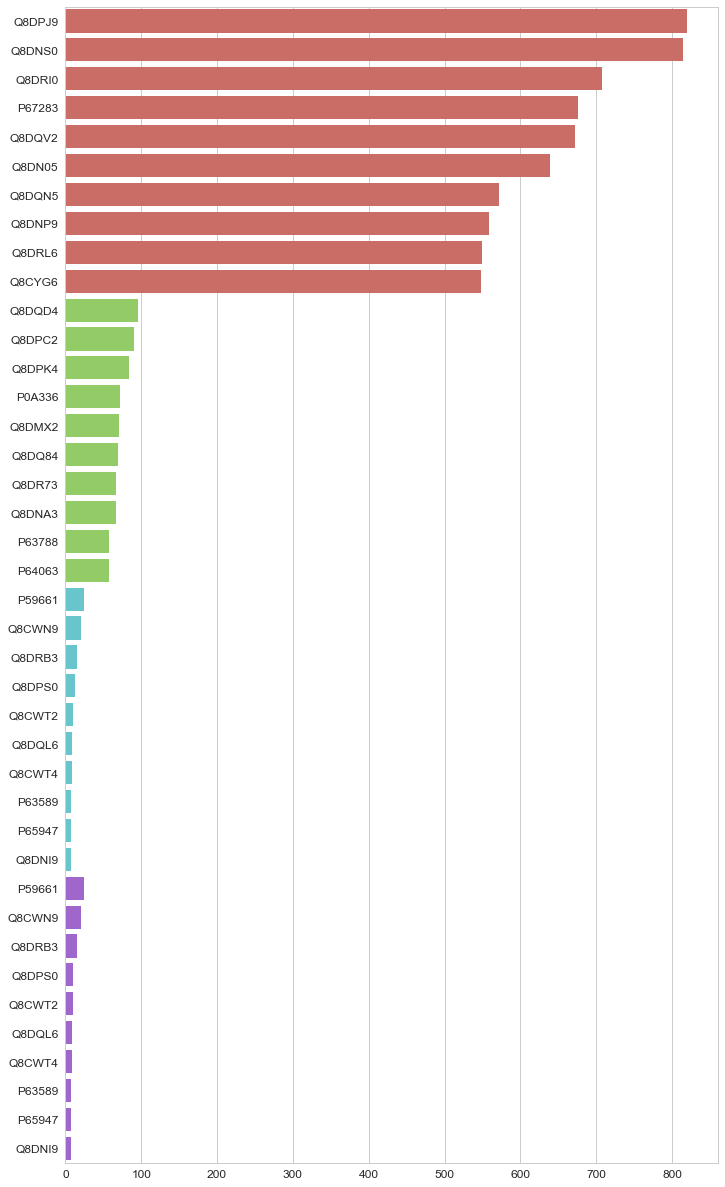

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

nFirst = 10
nThresh = 4

# Extract n first in each increasing threshold conditions
data_flat = []
_sim = list(gallery.keys())
_sim.sort()

for t in _sim:
    data_flat += gallery[t][:(nFirst)]

# Pick One color foreach treshold condition
# Inital set of even-spaced color
palette = sns.color_palette("hls", nThresh)

y_dummies = [ i + i%nThresh for i in range(0, len(data_flat) ) ]
y_dummies = [ i for i in range(0, len(data_flat) ) ]
x_degree  = [ d["degree"] for d in data_flat ]
y_labels  = [ d["nodeRef"] for d in data_flat ]

colors = []
c  = -1
_C = []
for i,e in enumerate(data_flat):
    if i%nFirst == 0:       
        c += 1
    colors.append(palette[c])
    _C.append(c)

sns.set(style="whitegrid", font_scale = 1.2)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(11.7, 21.27)
sns.set_color_codes("pastel")
sns.barplot(x=x_degree, y=y_dummies, orient='h', ax = ax, label="Total", palette=colors, ci=None)
ax.set_yticklabels(y_labels)

### Interactome enrichment and serialization

* Loading uniprot ressources
* Statistics on GO term occurences

In [12]:
%autoreload 2

# Development library
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteinsExt/src")
sys.path.append("/Users/guillaumelaunay/work/DVL/python3/pyproteins/src")

import pyproteinsExt.uniprot as uniprot
from pyproteinsExt.uniprot import EntryEncoder

import pyproteinsExt.annotators as aT

uColl = uniprot.getUniprotCollection()
uColl.setCache(location='/Users/guillaumelaunay/work/data/uniprot')
uniprot.proxySetting(https="http://ftprox.ibcp.fr:3128", http="http://ftprox.ibcp.fr:3128")

Acknowledged 2176 entries (/Users/guillaumelaunay/work/data/pfam)
Acknowledged 0 entries (/Users/guillaumelaunay)
Changing cache location to /Users/guillaumelaunay/work/data/uniprot
Reindexing /Users/guillaumelaunay/work/data/uniprot
Acknowledged 2275 entries (/Users/guillaumelaunay/work/data/uniprot)
!!Proxy set to {'https': 'http://ftprox.ibcp.fr:3128', 'http': 'http://ftprox.ibcp.fr:3128'}


##### Remark & example
A specific Uniprot object JSON serializer was developed for the task of writing a interactome.json file w/ uniprot data

In [54]:
import json
uObj = uColl.get('Q8DR57')
json.dumps(uObj, cls=EntryEncoder)

Acknowledged 2176 entries (/Users/guillaumelaunay/work/data/pfam)


'{"a": {"name": "GPSB_STRR6", "GO": [{"id": "GO:0005737", "term": "C:cytoplasm", "evidence": "ECO:0000501"}, {"id": "GO:0007049", "term": "P:cell cycle", "evidence": "ECO:0000501"}, {"id": "GO:0051301", "term": "P:cell division", "evidence": "ECO:0000501"}, {"id": "GO:0008360", "term": "P:regulation of cell shape", "evidence": "ECO:0000501"}]}}'

### Go Term analysis TO REWORK

 * Enriching a network in uniprot object
 * Returns a GO terms chart

In [11]:
class GoDict(object):
    
    def __init__(self):
        self.data = {}

    def addUniprotObj(self, uniprotObj):
        for g in uniprotObj.GO:
            if str(g) not in self.data:
                self.data[str(g)] = 0
            self.data[str(g)] += 1
            
    def sort(self):
        GoScore = [ (d, self.data[d]) for d in self.data ]
        GoScore.sort(key=lambda x:x[1], reverse=True)
        return GoScore


class GoScoreObj(object):
    def __init__(self, data):
        self.data = data
    def _repr_html_(self):
        htmlString = '<table><thead><th>GO term</th><th>Occurence</th></thead><tbody>'
        for t in self.data:
            htmlString += '<tr><td>' + str(t[0]) + '</td><td>' + str(t[1]) + '</td></tr>'

        htmlString += '</tbody></table>'

        return htmlString

def uniprotObjListGoScore(uniprotObjList):
    goDict = GoDict()
    for uniprotObj in uniprotObjList:
        goDict.addUniprotObj(uniprotObj)
        
    return goDict.sort()
    
def GOchartGraph(G):
    for n in G.nodes():
        if 'uniprot' in G.node[n]:
            continue
        G.node[n]['uniprot'] = uColl.get(str(n))
        
    uniprotObjList = [ G.node[n]["uniprot"] for n in G.nodes() if G.node[n]["uniprot"] ]
    return GoScoreObj( uniprotObjListGoScore(uniprotObjList) )
   
def GOneighbouring(G, nodeName, radius=1):
    _g = nx.ego_graph(G, nodeName, radius)
    uniProtRefQuery = {}
    uniProtRefTemplate = {}
    
    for e in _g.edges():
        if str(e[0]) not in uniProtRefQuery:
            uniProtRefQuery[ str(e[0]) ] = 'query' 
        if str(e[1]) not in uniProtRefQuery:
            uniProtRefQuery[ str(e[1]) ] = 'query'  
        
        edgeDatum = G.get_edge_data(*e)       
        for _param in edgeDatum['lowQueryParam'] + edgeDatum['highQueryParam']:
            if _param[9] not in uniProtRefTemplate:
                uniProtRefTemplate[ _param[9] ] = 'template'
            
    print (len(uniProtRefTemplate.keys()), ' Templates and ',len(uniProtRefQuery.keys()), ' Queries uniprot entities to create')
    uniprotObjListQ = [ uColl.get(k) for k in uniProtRefQuery ]
    uniprotObjListQ = [ e for e in uniprotObjListQ if e ]
    goScoreQ = GoScoreObj( uniprotObjListGoScore(uniprotObjListQ) )
    
    uniprotObjListT = [ uColl.get(k) for k in uniProtRefTemplate ]
    uniprotObjListT = [ e for e in uniprotObjListT if e ]
    goScoreT = GoScoreObj( uniprotObjListGoScore(uniprotObjListT) )
    return (goScoreQ, goScoreT)

In [109]:
(goScoreQ, goScoreT) = GOneighbouring(G, "P0A2W7")

6  Templates and  6  Queries uniprot entities to create
got to fetch Q8CWN9
got to fetch Q8CWN9
got to fetch P59661
got to fetch P59661
got to fetch Q8CWT4
got to fetch Q8CWT4
got to fetch Q8CWT2
got to fetch Q8CWT2
got to fetch Q8DRB3
got to fetch Q8DRB3
got to fetch Q97NV3
got to fetch Q97NV3
got to fetch P0A2W6
got to fetch P0A2W6
got to fetch Q97SE5
got to fetch Q97SE5
got to fetch Q97S73
got to fetch Q97S73
got to fetch P95830
got to fetch P95830
got to fetch Q97SR4
got to fetch Q97SR4


##### Dumping network and auxilliary uniprot data in the same `interactome.json` file

In [51]:
networkEnriched = nEncode(G)
networkEnriched['registry'] = uniprotRegistry
fOut = "/Users/guillaumelaunay/work/projects/pneumocoque/3Dnetwork/3D_force/networks/interactome_40id_enriched.json"
with open(fOut, 'w') as outfile:
    json.dump(networkEnriched, outfile, cls=EntryEncoder)




In [72]:
goScoreT

GO:0005737:C:cytoplasm{ECO:0000501},1
GO:0005524:F:ATP binding{ECO:0000501},1
GO:0042802:F:identical protein binding{ECO:0000314},1
GO:0004595:F:pantetheine-phosphate adenylyltransferase activity{ECO:0000314},1
GO:0015937:P:coenzyme A biosynthetic process{ECO:0000314},1
GO:0005829:C:cytosol{ECO:0000314},1
GO:0022625:C:cytosolic large ribosomal subunit{ECO:0000314},1
GO:0015934:C:large ribosomal subunit{ECO:0000315},1
GO:0042788:C:polysomal ribosome{ECO:0000315},1
GO:0032993:C:protein-DNA complex{ECO:0000315},1
"GO:0001217:F:bacterial-type RNA polymerase transcriptional repressor activity, sequence-specific DNA binding{ECO:0000315}",1


In [ ]:
def GoPick(G, nodeName):    
    nx.ego_graph(G, nodeName, radius)
    # list Each node template
    # Try to fetch GO term
    

In [37]:
GOchart(G)

got to fetch Q8DNE6
got to fetch Q8DNE6
got to fetch P66855
got to fetch P66855
got to fetch Q8CWU4
got to fetch Q8CWU4
got to fetch Q8DP77
got to fetch Q8DP77
got to fetch Q8DQ45
got to fetch Q8DQ45
got to fetch Q8DPU8
got to fetch Q8DPU8
got to fetch Q8DPK7
got to fetch Q8DPK7
got to fetch P0A452
got to fetch P0A452
got to fetch Q7CRB2
got to fetch Q7CRB2
got to fetch P0A4M6
got to fetch P0A4M6
got to fetch Q8DMX2
got to fetch Q8DMX2
got to fetch Q9EUQ7
got to fetch Q9EUQ7
got to fetch Q8DMX3
got to fetch Q8DMX3
got to fetch Q8DQR7
got to fetch Q8DQR7
got to fetch Q8DPN1
got to fetch Q8DPN1
got to fetch Q8DPC2
got to fetch Q8DPC2
got to fetch Q8DN59
got to fetch Q8DN59
got to fetch Q8DQD4
got to fetch Q8DQD4
got to fetch Q8CWN9
got to fetch Q8CWN9
got to fetch Q8DPN5
got to fetch Q8DPN5
got to fetch Q8CWR3
got to fetch Q8CWR3
got to fetch Q8DPZ4
got to fetch Q8DPZ4
got to fetch Q8DPK4
got to fetch Q8DPK4
got to fetch Q8DPM2
got to fetch Q8DPM2
got to fetch Q8DRQ3
got to fetch Q8DRQ3


GO:0005524:F:ATP binding{ECO:0000501},84
GO:0005737:C:cytoplasm{ECO:0000501},64
GO:0046872:F:metal ion binding{ECO:0000501},30
GO:0005829:C:cytosol{ECO:0000318},28
GO:0003677:F:DNA binding{ECO:0000501},25
GO:0005737:C:cytoplasm{ECO:0000318},22
GO:0003735:F:structural constituent of ribosome{ECO:0000318},21
GO:0006412:P:translation{ECO:0000501},17
GO:0019843:F:rRNA binding{ECO:0000501},16
GO:0006412:P:translation{ECO:0000318},14
GO:0005525:F:GTP binding{ECO:0000501},12
